<a href="https://colab.research.google.com/github/GenAIUnplugged/tensorflow_series/blob/main/CNN_Models_Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
(df_train,ds_test),ds_info = tfds.load('tf_flowers',
                                        split=['train[:70%]','train[70%:]'],
                                        as_supervised=True,
                                        with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.7B0KM1_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
})

In [ ]:
num_classes = ds_info.features['label'].num_classes
num_classes

5

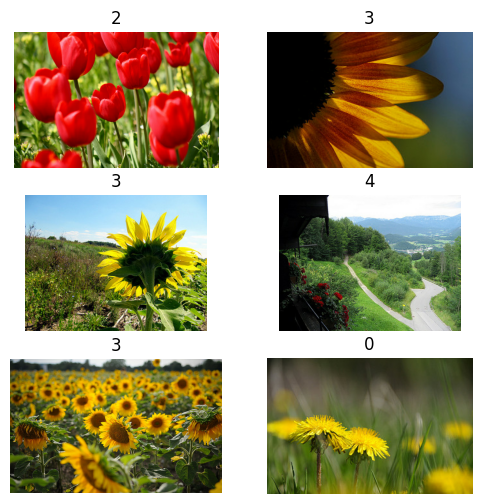

In [ ]:
plt.figure(figsize=(6,6))
for i,(image,label) in enumerate(df_train.take(6)):
  plt.subplot(3,2,i+1)
  plt.imshow(image.numpy().astype('uint8'))
  plt.title(str(label.numpy()))
  plt.grid(False)
  plt.axis('off')
plt.show()

In [ ]:
def preprocess(image,label):
  resized_image = tf.image.resize(image,[128,138])
  image = tf.cast(resized_image,tf.float32)/255.0
  return image,label

In [ ]:
df_train = df_train.map(preprocess,num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess,num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
df_train = df_train.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.cache().batch(32).prefetch(tf.data.AUTOTUNE)

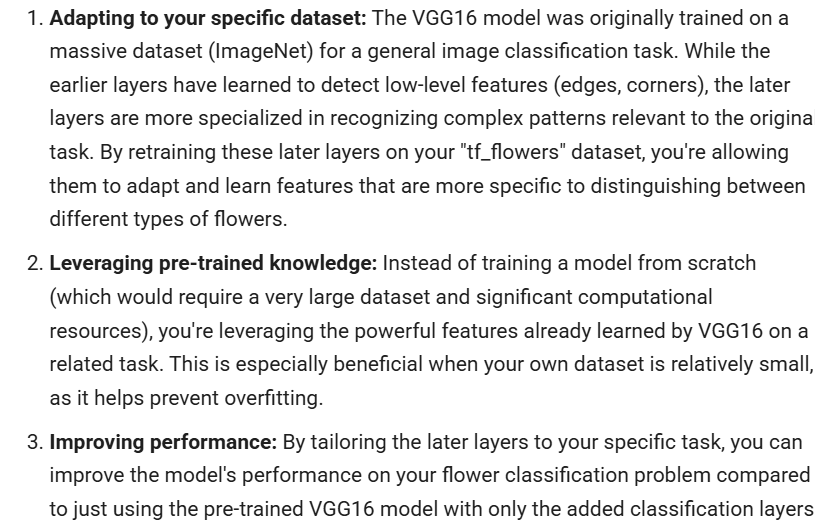

# VGG Model

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout,GlobalAveragePooling2D,MaxPooling2D

In [ ]:
vgg_model = VGG16(weights='imagenet',include_top=False,input_shape=(128,138,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
vgg_model.trainable = True

In [ ]:
#Choose how many layers to fine tune
#We will unfreeze and train the last 4 layers
for layer in vgg_model.layers[:-4]:
  layer.trainable = False

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(monitor='val_loss',patience=5,verbose=1)

In [ ]:
model = Sequential([
    vgg_model,
    GlobalAveragePooling2D(),
    Dense(num_classes,activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,717,253 (56.14 MB)

 Trainable params: 7,081,989 (27.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(df_train,validation_data=ds_test,epochs=10,callbacks=[earlystopping])

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 0.2778 - loss: 1.7735 - val_accuracy: 0.3697 - val_loss: 1.5388
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 0.4911 - loss: 1.1473 - val_accuracy: 0.5995 - val_loss: 1.0668
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.6802 - loss: 0.8207 - val_accuracy: 0.7012 - val_loss: 0.8118
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.7872 - loss: 0.5786 - val_accuracy: 0.7657 - val_loss: 0.7094
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - accuracy: 0.8286 - loss: 0.4417 - val_accuracy: 0.8256 - val_loss: 0.6647
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9025 - loss: 0.2916 - val_accuracy: 0.8510 - val_loss: 0.6088
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 161ms/step - accuracy: 0.9233 - loss: 0.2041 - val_accuracy: 0.8447 - val_loss: 0.4735
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9135 - loss: 0.2292 - val_accu

In [ ]:
loss,acc = model.evaluate(ds_test)
print('Loss:',loss)
print('Accuracy:',acc)

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.8574 - loss: 0.5356
Loss: 0.5681853890419006
Accuracy: 0.8610354065895081


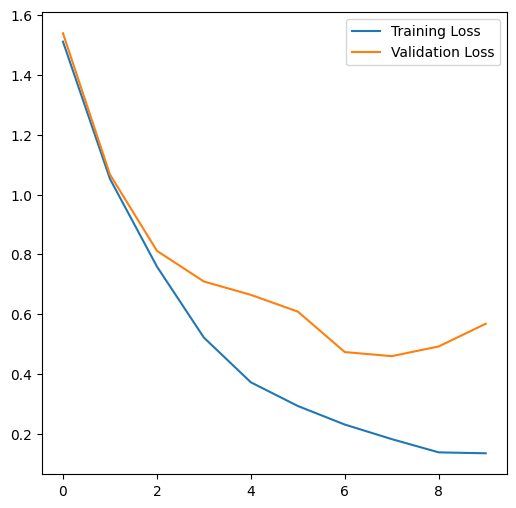

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()
plt.show()

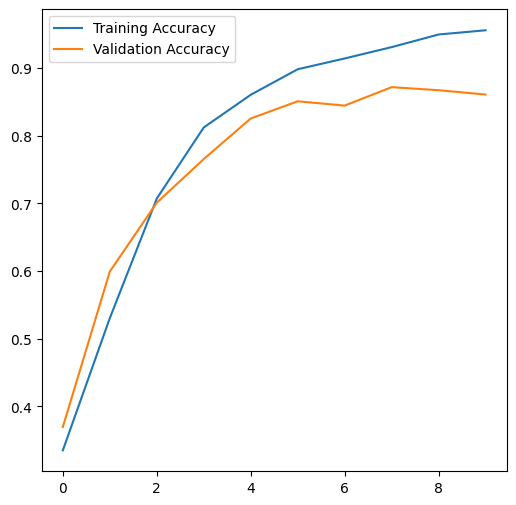

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.applications import ResNet50

In [ ]:
restnet = ResNet50(weights='imagenet',include_top=False,input_shape=(128,138,3))

In [ ]:
restnet.trainable = True
for layer in restnet.layers[:-4]:
  layer.trainable = False

In [ ]:
model = Sequential([
    restnet,
    GlobalAveragePooling2D(),
    Dense(num_classes,activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(df_train,validation_data=ds_test,epochs=10,callbacks=[earlystopping])

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 150ms/step - accuracy: 0.3654 - loss: 1.5315 - val_accuracy: 0.3124 - val_loss: 1.6972
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.4605 - loss: 1.3286 - val_accuracy: 0.4387 - val_loss: 1.3857
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.4883 - loss: 1.2744 - val_accuracy: 0.3642 - val_loss: 1.4349
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5082 - loss: 1.2329 - val_accuracy: 0.3715 - val_loss: 1.4588
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.5094 - loss: 1.2448 - val_accuracy: 0.3896 - val_loss: 1.6152
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.5177 - loss: 1.2123 - val_accuracy: 0.3270 - val_loss: 1.7518
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.5388 - loss: 1.1733 - val_accuracy: 0.4196 - val_loss: 1.6238
Epoch 7: early stopping


In [ ]:
loss,acc = model.evaluate(ds_test)
print('Loss:',loss)
print('Accuracy:',acc)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4284 - loss: 1.5889
Loss: 1.6237735748291016
Accuracy: 0.41961851716041565


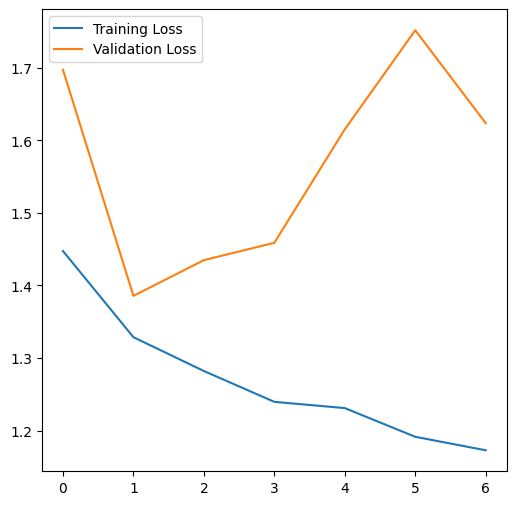

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()
plt.show()

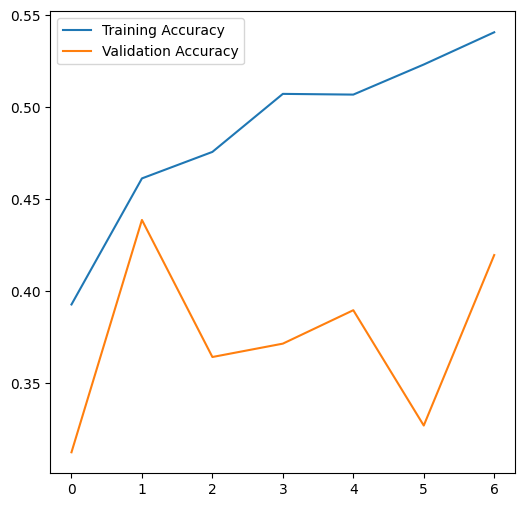

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.legend()